In [2]:
import os, sys
sys.path.append("..")

In [3]:
from tensorized_algorithm import pauli_utils
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from functools import reduce

from qiskit.quantum_info import SparsePauliOp

# Error by applying orders

In the document, we test the Trotter error by applying ordering of each local Hamiltonian.

**Question**

How much error rate is generated, if we apply the commuting partition order, in Trotterization circuit?.

Common error rate of p-th order Trotterization is $O(t^{p+1})$. In "Theory of Trotter Error" paper, they derived a $\alpha$ constant for $O(\alpha t^{p+1})$.


**Observation**

In simple system, $n<3$, the commuting pair errors were 2-10 times larger than random sequence.
However, in larger and complicated systems, $n>4$, the commuting order averagely show good error rates.
The efficiency is getting better as $t$ increases in $\exp(-it H)$.

In [4]:
def mat_diff(A, B):
    U = np.matrix(A - B)
    return 0.5*pauli_utils.fro_inner(U, U)
def matmul(a,b):
    return a@b
def get_U_l(hs, n, t):
    tn = t/n
    us = [expm(-1j*tn*h) for h in hs]
    ut = reduce(matmul, us)
    U = np.eye(ut.shape[0], dtype=complex)
    for i in range(n):
        U @= ut
    return U

In [97]:
N = 4
A = np.random.rand(int(2**N), int(2**N))
T = A.T@A
H = np.matrix((T + 1j*T))
norm_H = 0.5*pauli_utils.fro_inner(H, H)
H *= 1/np.sqrt(norm_H) 


In [98]:
pa = SparsePauliOp.from_operator(H)

In [99]:
pa.group_commuting()

[SparsePauliOp(['IIIX', 'IIXI', 'IIXX', 'IXII', 'IXIX', 'IXXI', 'IXXX', 'XIII', 'XIIX', 'XIXI', 'XIXX', 'XXII', 'XXIX', 'XXXI', 'XXXX', 'IIII'],
               coeffs=[0.25434473+0.25434473j, 0.24678807+0.24678807j, 0.24330745+0.24330745j,
  0.23566756+0.23566756j, 0.24594322+0.24594322j, 0.24314162+0.24314162j,
  0.24169289+0.24169289j, 0.25030892+0.25030892j, 0.23910866+0.23910866j,
  0.2472259 +0.2472259j , 0.2338246 +0.2338246j , 0.23121197+0.23121197j,
  0.22700332+0.22700332j, 0.22493235+0.22493235j, 0.24260389+0.24260389j,
  0.31852795+0.31852795j]),
 SparsePauliOp(['IIIZ', 'IIXZ', 'IXIZ', 'IXXZ', 'XIIZ', 'XIXZ', 'XXIZ', 'XXXZ'],
               coeffs=[-0.02027012-0.02027012j, -0.02707862-0.02707862j, -0.00775386-0.00775386j,
  -0.01731005-0.01731005j, -0.02710343-0.02710343j, -0.02375936-0.02375936j,
  -0.01513991-0.01513991j, -0.02611021-0.02611021j]),
 SparsePauliOp(['IIYY', 'IIZX', 'IXYY', 'IXZX', 'XIYY', 'XIZX', 'XXYY', 'XXZX'],
               coeffs=[-0.00579396-0.00579396

In [100]:
Hs = pa.matrix_iter()
H_com_group = [h.to_matrix() for h in pa.group_commuting()]

In [101]:
len(Hs), len(H_com_group)

(136, 21)

In [102]:
pauli_utils.fro_inner(np.matrix(H), np.matrix(H))/2

(0.9999999999999996-8.71927246868554e-19j)

In [103]:
identit_index = [i for i in range(len(H_com_group))]
random_index = [i for i in range(len(Hs))]
shuffle(random_index)

In [104]:
def get_U_n(hs, n, t, rand_index): #get general order u
    tn = t/n    
    us = [np.matrix(expm(-1j*tn*hs[i])) for i in rand_index]
    ut = reduce(matmul, us)
    U = np.eye(ut.shape[0], dtype=complex)
    for i in range(n):
        U @= ut
    return U


In [107]:
n = N
t = 0.03
U = expm(-1j*t*H)
Ug = get_U_n(Hs, N, t, random_index)
Uc = get_U_n(H_com_group, N, t, identit_index)

##

$$U \approx $$

$$U_1 U_2 U_3,$$


$$U_2 U_3 U_1,$$


$$U_3 U_2 U_1,$$


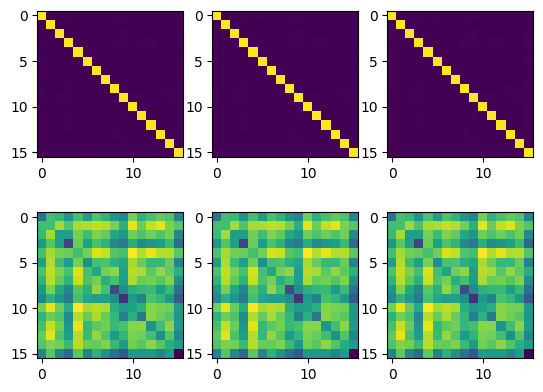

In [108]:
fig, axes = plt.subplots(2, 3)
axes[0, 0].imshow(U.real)
axes[1, 0].imshow(U.imag)

axes[0, 1].imshow(Ug.real)
axes[1, 1].imshow(Ug.imag)

axes[0, 2].imshow(Uc.real)
axes[1, 2].imshow(Uc.imag)

In [109]:
mat_diff(U, Ug).real, mat_diff(U, Uc).real

(1.523773062891032e-09, 1.136536609225727e-08)

In [110]:
from copy import deepcopy

In [111]:
from opttrot.pauli_utils import pstr_commute

In [112]:
n = 4
errs = []
ts = np.linspace(0.8, 1.4, 50)
pplist = pa.to_list()
max_i = len(Hs)

for t in ts:
    U = expm(-1j*t*H)
    err_coms = []
    iter1 = 2000
    for i in range(iter1):
        shuffle(H_com_group)
        Uc = get_U_n(H_com_group, n, t, identit_index)
        err_com = mat_diff(U, Uc)
        err_coms.append(err_com)
    
    err = []
    min_err = err_com 
    optimal_index = None
    iter2 = 5000
    for l in range(iter):
        random_index = [i for i in range(len(Hs))]
        shuffle(random_index)
        Ug = get_U_n(Hs, n, t, random_index)
        err_c =mat_diff(U, Ug).real
        err.append(err_c)
        if min_err > err_c :
            optimal_index = deepcopy(random_index)
            min_err = err_c
    
    if optimal_index is not None:
        commute = []
        for i, j in enumerate(optimal_index):
            if i +1 >= max_i:
                break
            p1 = pplist[j][0]
            p2 = pplist[optimal_index[i+1]][0]
            commute.append(pstr_commute(p1, p2))
        commute = np.array(commute)
        M = max_i-1
        commute_num = commute.sum()
        cn = commute_num/M
        acn = 1-cn
        print(f"Commute ratio: {cn:.2}/{acn:.2}")
        print(commute)
    
    e_max = max(err)
    e_min = min(err)
    percentage = (100*(np.abs(min(err_coms)))/e_max).real
    errs.append(percentage)
    print(f"{n}, {t:.3}", f"{percentage:.2}%", )

KeyboardInterrupt: 

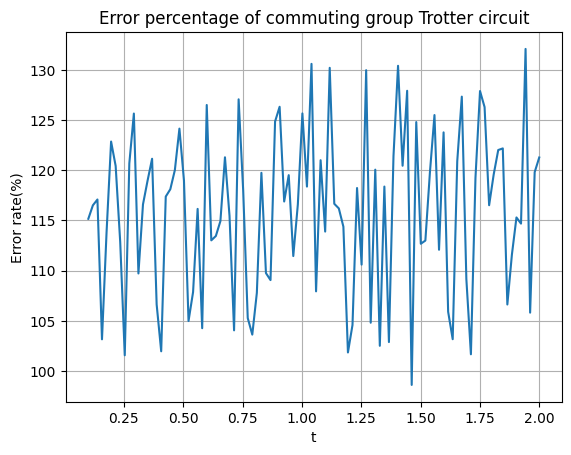

In [18]:
plt.plot(ts[:len(errs)], errs[-len(errs):])
plt.title("Error percentage of commuting group Trotter circuit")
plt.xlabel("t")
plt.ylabel("Error rate(%)")
plt.grid()

In [113]:
from copy import deepcopy

In [114]:
t = 0.03
n = N
U = expm(-1j*t*H)

err_coms = []
index_min = None
for i in range(1000):
    index_com = [i for i in range(len(H_com_group))]
    shuffle(index_com)
    Uc = get_U_n(H_com_group, n, t, index_com)
    err_com = mat_diff(U, Uc)
    err_coms.append(err_com)
    if err_com <= min(err_coms):
        index_min = deepcopy(index_com)
err_com = min(err_coms)



In [115]:
err_com.real

2.3424221082494384e-09

In [116]:
err = []
min_err = err_com 
optimal_index = None
iter1 = 1000
for l in range(iter1):
    print(f"{l}/{iter1}")
    
    random_index = [i for i in range(len(Hs))]
    shuffle(random_index)
    Ug = get_U_n(Hs, n, t, random_index)
    err_c =mat_diff(U, Ug).real
    err.append(err_c)
    if min_err > err_c :
        optimal_index = deepcopy(random_index)
        min_err = err_c
    
e_max = max(err)
e_min = min(err)
percentage = (100*(err_com - e_min)/e_max).real

0/1000
1/1000
2/1000
3/1000
4/1000
5/1000
6/1000
7/1000
8/1000
9/1000
10/1000
11/1000
12/1000
13/1000
14/1000
15/1000
16/1000
17/1000
18/1000
19/1000
20/1000
21/1000
22/1000
23/1000
24/1000
25/1000
26/1000
27/1000
28/1000
29/1000
30/1000
31/1000
32/1000
33/1000
34/1000
35/1000
36/1000
37/1000
38/1000
39/1000
40/1000
41/1000
42/1000
43/1000
44/1000
45/1000
46/1000
47/1000
48/1000
49/1000
50/1000
51/1000
52/1000
53/1000
54/1000
55/1000
56/1000
57/1000
58/1000
59/1000
60/1000
61/1000
62/1000
63/1000
64/1000
65/1000
66/1000
67/1000
68/1000
69/1000
70/1000
71/1000
72/1000
73/1000
74/1000
75/1000
76/1000
77/1000
78/1000
79/1000
80/1000
81/1000
82/1000
83/1000
84/1000
85/1000
86/1000
87/1000
88/1000
89/1000
90/1000
91/1000
92/1000
93/1000
94/1000
95/1000
96/1000
97/1000
98/1000
99/1000
100/1000
101/1000
102/1000
103/1000
104/1000
105/1000
106/1000
107/1000
108/1000
109/1000
110/1000
111/1000
112/1000
113/1000
114/1000
115/1000
116/1000
117/1000
118/1000
119/1000
120/1000
121/1000
122/1000
123

In [117]:
percentage

42.3578868744875

In [118]:
index_min 

[16, 15, 12, 9, 17, 8, 0, 7, 18, 13, 10, 3, 19, 1, 5, 14, 11, 6, 4, 20, 2]

Text(0, 0.5, 'Relatuve errors')

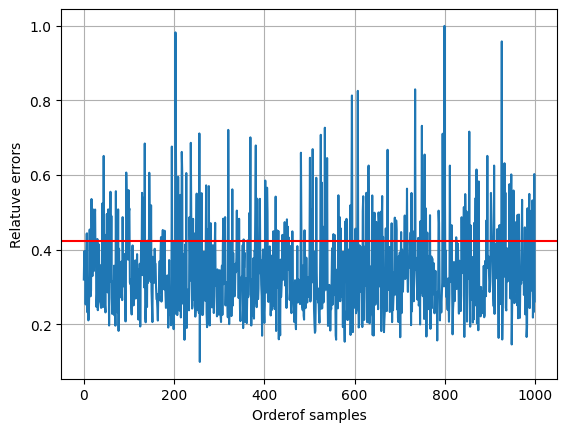

In [122]:
plt.plot(err/e_max)
plt.axhline((err_com - e_min)/e_max, 0, iter1, c="r")
plt.grid()
plt.xlabel("Orderof samples")
plt.ylabel("Relatuve errors")

In [67]:
min_err

0.013138065863168406

In [71]:
U.shape

(16, 16)

In [864]:
from opttrot.pauli_utils import pstr_commute

In [870]:
pplist = pa.to_list()
max_i = len(optimal_index)
print(max_i)
commute = []
for i, j in enumerate(optimal_index):
    if i +1 >= max_i:
        break

    pa = pplist[j][0]
    pb = pplist[optimal_index[i+1]][0]

    commute.append(pstr_commute(pa, pb))
commute = np.array(commute)

135


In [873]:
commute

array([False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True, False, False, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False,  True, False, False, False,
        True,  True,  True, False,  True, False, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True, False, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False,  True, False,
        True,  True,

In [876]:
commute.sum()/(max_i-1), (max_i-1 -commute.sum())/(max_i-1)

(0.5, 0.5)